In [1]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr


In [2]:
import cv2
import numpy as np
from data_utils import JeongganboReader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

np.set_printoptions(threshold=np.inf, linewidth=np.inf)

reader = JeongganboReader()

# Load Daegeum Yeo-Min-Rock Jeonggan-bo

In [3]:
inst = {
  "name": 'daegeum',
  "start": 17, # page 17 ~ 36
  "num_page": 20
}

# ymr: yeo min rock
ymr_paths = [f'pngs/{inst["name"]}_pg-{str(idx + inst["start"]).zfill(3)}.png' for idx in range(inst["num_page"])]
ymr = reader.parse_multiple_pages(ymr_paths)

Processing pngs/daegeum_pg-017.png
No jeonggan detected at pngs/daegeum_pg-017.png
Processing pngs/daegeum_pg-018.png
No jeonggan detected at pngs/daegeum_pg-018.png
Processing pngs/daegeum_pg-019.png
No jeonggan detected at pngs/daegeum_pg-019.png
Processing pngs/daegeum_pg-020.png
Processing pngs/daegeum_pg-021.png
Processing pngs/daegeum_pg-022.png
Processing pngs/daegeum_pg-023.png
Processing pngs/daegeum_pg-024.png
Processing pngs/daegeum_pg-025.png
Processing pngs/daegeum_pg-026.png
Processing pngs/daegeum_pg-027.png
Processing pngs/daegeum_pg-028.png
Processing pngs/daegeum_pg-029.png
Processing pngs/daegeum_pg-030.png
Processing pngs/daegeum_pg-031.png
Processing pngs/daegeum_pg-032.png
Processing pngs/daegeum_pg-033.png
Processing pngs/daegeum_pg-034.png
Processing pngs/daegeum_pg-035.png
Processing pngs/daegeum_pg-036.png


# define Jeonggan generator
* for ease of cycle through Jeonggans

In [4]:
ymr_gaks_w_jangdan = ymr[0].gaks
ymr_gaks = list(filter(lambda x: not x.is_jangdan, ymr_gaks_w_jangdan))

def make_jeonggan_generator(gaks):
  for gak in gaks:
    for jng in gak.jeonggans:
      yield jng.img, reader._process_img(jng.img)

## make jeonggan generator and list

In [5]:
jng_gen = make_jeonggan_generator(ymr_gaks)

jng_list = list(make_jeonggan_generator(ymr_gaks))
len(jng_list)

3200

# Load pattern image paths

In [6]:
import glob

pattern_path_base = 'test/daegeum/'
pattern_path_sub = ['notations/', 'pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

In [7]:
print([ name for name in pattern_paths['notations'].keys() ])
print([ name for name in pattern_paths['pitches'].keys() ])

['pause', 'no_ni_ro', 'neu_na', 'ri', 'ni_na', 'ne_ro_ne', 'yo', 'neu_ne_neu', 'neu_na_reu_na_ni', 'dn_flow', 'neu_na_ni_na', 'no', 'dn_yo', 'niro', 'none', 'ro', 'ni_ro_na', 'nire', 'neo_nye', 'flow', 'push', 'ne_ro_na', 'dn_push', 'no_ri_no', 'ni', 'nina', 'conti', 'neu_ni', 'na_nue_na', 'accent', 'na_ni_na', 'no_ra', 'ni_neu_ra_ni', 'ni_re_na']
['nam_d', 'hwang_u', 'jonng', 'nam_u', 'tae_u', 'lim_d', 'tae', 'mu', 'joong_u', 'mu_d', 'nam', 'mu_u', 'lim_u', 'lim', 'hwang_uu', 'hwang']


# openCV SIFT matching test

## test summary
* jeonggan range: [0:20] (first Gak of Yeo-Min-Rock)
* target pitches
    * lim
    * lim_u
    * hwang_u
    * nam
    * joong_u
    * tae_u
* target notations
    * conti
    * pause
    * push
    * no
    * ni
    * ni_na
    * neu_na
    * ni_re
    * ni_na
    * no_ni_no

In [8]:
target_jng_list = jng_list

### MEMO
* result of cv2.matchTemplate's shape
    * height: image.shape[0] - template.shape[0] + 1
    * width: image.shape[1] - template.shape[1] + 1

## SIFT-BFM matching function
* BFM: Brute Force Matcher

In [9]:
def SIFT_BFM(jng, char, norm=cv2.NORM_L1, ratio=0.3):
  jng_rs = cv2.resize(jng, (300, 300))
  char_rs = cv2.resize(char, (300, 300))

  jng_gray = cv2.cvtColor (jng_rs, cv2.COLOR_BGR2GRAY)
  char_gray = cv2.cvtColor(char_rs, cv2.COLOR_BGR2GRAY)

  detector = cv2.xfeatures2d.SIFT_create()

  jng_kp, jng_desc = detector.detectAndCompute(jng_gray, None)
  char_kp, char_desc = detector.detectAndCompute(char_gray, None)

  matcher = cv2.BFMatcher(norm, crossCheck=True)

  matches = matcher.match(char_desc, jng_desc)
  matches = sorted(matches, key = lambda x:x.distance)

  max_dist, min_dist = matches[-1].distance, matches[0].distance

  boundary = (max_dist - min_dist) * ratio + min_dist
  correct_matches = [m for m in matches if m.distance < boundary]

  return cv2.drawMatches(char_rs, char_kp, jng_rs, jng_kp, correct_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

[ WARN:0@16.038] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


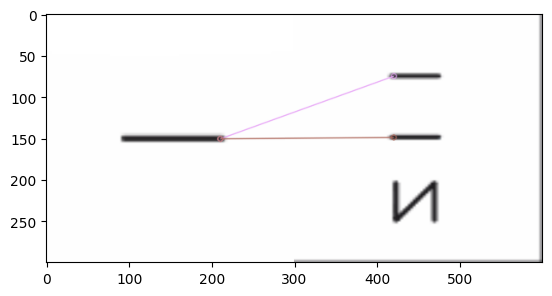

In [10]:
ratio = 0.9

jng, _ = target_jng_list[1] # second jeonggan on Yeo-Min-Rock
conti = cv2.imread(pattern_paths['notations']['conti'])

result_conti = SIFT_BFM(jng, conti, norm=cv2.NORM_L2, ratio=ratio)

plt.imshow(result_conti)

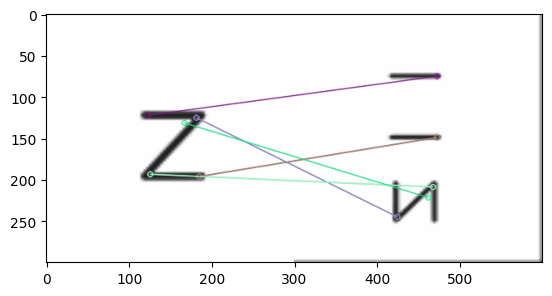

In [11]:
ratio = 0.3

ni_na = cv2.imread(pattern_paths['notations']['neu_na'])

result_ni_na = SIFT_BFM(jng, ni_na, norm=cv2.NORM_L2, ratio=ratio)

plt.imshow(result_ni_na)

## SIFT-FBM Matching function
* FBM: Flann Based Matcher

In [12]:
def SIFT_FBM(jng, char):
  jng_rs = cv2.resize(jng, (300, 300))
  char_rs = cv2.resize(char, (300, 300))

  jng_gray = cv2.cvtColor (jng_rs, cv2.COLOR_BGR2GRAY)
  char_gray = cv2.cvtColor(char_rs, cv2.COLOR_BGR2GRAY)

  detector = cv2.xfeatures2d.SIFT_create()

  jng_kp, jng_desc = detector.detectAndCompute(jng_gray, None)
  char_kp, char_desc = detector.detectAndCompute(char_gray, None)

  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=16)
  search_params = dict(checks=30)

  matcher = cv2.FlannBasedMatcher(index_params, search_params)

  matches = matcher.match(char_desc, jng_desc)
  
  return cv2.drawMatches(char_rs, char_kp, jng_rs, jng_kp, matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

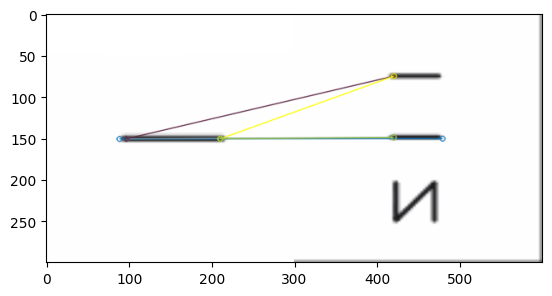

In [13]:
jng, _ = target_jng_list[1] # second jeonggan on Yeo-Min-Rock
conti = cv2.imread(pattern_paths['notations']['conti'])

result_conti = SIFT_FBM(jng, conti)

plt.imshow(result_conti)

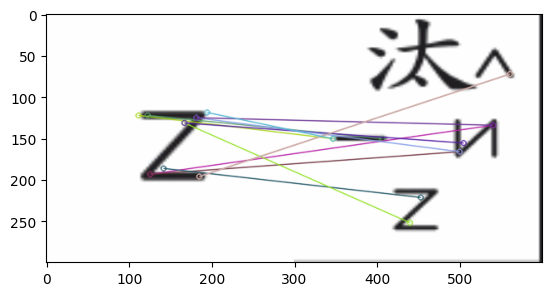

In [14]:
jng, _ = target_jng_list[171]
char = cv2.imread(pattern_paths['notations']['neu_na'])

result = SIFT_FBM(jng, char)

plt.imshow(result)

## ORB-BFM Matching function

In [15]:
def ORB_BFM(jng, char, norm=cv2.NORM_HAMMING, ratio=0.3):
  jng_rs = cv2.resize(jng, (300, 300))
  char_rs = cv2.resize(char, (300, 300))

  jng_gray = cv2.cvtColor (jng_rs, cv2.COLOR_BGR2GRAY)
  char_gray = cv2.cvtColor(char_rs, cv2.COLOR_BGR2GRAY)

  detector = cv2.ORB_create()

  jng_kp, jng_desc = detector.detectAndCompute(jng_gray, None)
  char_kp, char_desc = detector.detectAndCompute(char_gray, None)

  matcher = cv2.BFMatcher(norm, crossCheck=True)

  matches = matcher.match(char_desc, jng_desc)
  matches = sorted(matches, key = lambda x:x.distance)

  max_dist, min_dist = matches[-1].distance, matches[0].distance

  boundary = (max_dist - min_dist) * ratio + min_dist
  correct_matches = [m for m in matches if m.distance < boundary]
  
  print(correct_matches)

  return cv2.drawMatches(char_rs, char_kp, jng_rs, jng_kp, correct_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

[< cv2.DMatch 0x7f76bd3a9430>, < cv2.DMatch 0x7f76bd3a9e70>, < cv2.DMatch 0x7f76bd3a94d0>, < cv2.DMatch 0x7f76bd3a96f0>, < cv2.DMatch 0x7f76bd3a9b70>, < cv2.DMatch 0x7f76bd3a9650>]


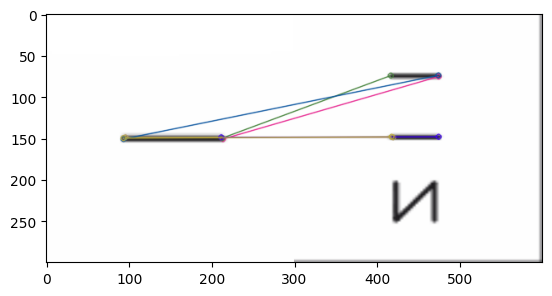

In [16]:
ratio = 0.5

jng, _ = target_jng_list[1] # second jeonggan on Yeo-Min-Rock
conti = cv2.imread(pattern_paths['notations']['conti'])

result_conti = ORB_BFM(jng, conti, ratio=ratio)

plt.imshow(result_conti)

[< cv2.DMatch 0x7f76bc2b1090>, < cv2.DMatch 0x7f76bc2b1690>, < cv2.DMatch 0x7f76bc2b17f0>, < cv2.DMatch 0x7f76bc2b1850>, < cv2.DMatch 0x7f76bc2b1870>, < cv2.DMatch 0x7f76bc2b16b0>, < cv2.DMatch 0x7f76bc2b18d0>, < cv2.DMatch 0x7f76bc2b1030>, < cv2.DMatch 0x7f76bc2b1310>, < cv2.DMatch 0x7f76bc2b1430>, < cv2.DMatch 0x7f76bc2b10f0>, < cv2.DMatch 0x7f76bc2b17d0>, < cv2.DMatch 0x7f76bc2b1810>, < cv2.DMatch 0x7f76bc2b1830>, < cv2.DMatch 0x7f76bc2b18b0>, < cv2.DMatch 0x7f76bc2b10d0>, < cv2.DMatch 0x7f76bc2b1790>, < cv2.DMatch 0x7f76bc2b1750>, < cv2.DMatch 0x7f76bc2b17b0>, < cv2.DMatch 0x7f76bc2b1890>]


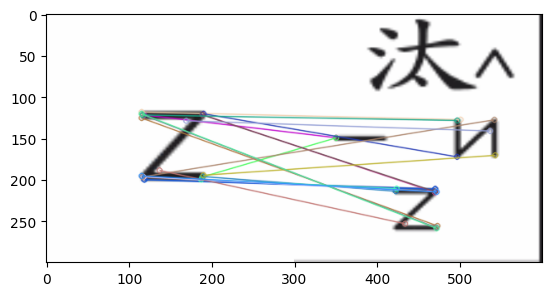

In [17]:
ratio = 0.1

jng, _ = target_jng_list[171]
char = cv2.imread(pattern_paths['notations']['neu_na'])

result = ORB_BFM(jng, char, norm=cv2.NORM_HAMMING2, ratio=ratio)

plt.imshow(result)